# 데이터 전처리 파이프라인

이 노트북은 ECOS 경제지표와 DART 재무데이터를 각각 독립적으로 전처리합니다.

## 처리 개요

1. **ECOS 경제지표**: 월별 데이터 처리 (2010년부터)
2. **DART 재무데이터**: 분기별 재무제표 처리 (2015 Q4부터)

각 섹션은 독립적으로 실행 가능하며, 서로 다른 모델에서 활용됩니다.

In [35]:
# 공통 패키지 설치 (한 번만 실행)
!pip install pandas numpy matplotlib seaborn scikit-learn python-dotenv mysql-connector-python

In [28]:
# 공통 설정 (한글 폰트, 경고 무시)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 필요한 패키지들 import
import pandas as pd
import numpy as np
import os
import sys

# 현재 디렉토리와 DB 폴더 경로 확인
current_dir = os.getcwd()
print(f"현재 작업 디렉토리: {current_dir}")

# DB 폴더 경로 (preprocessing 폴더에서 상위로 올라가서 DB 폴더로)
parent_dir = os.path.dirname(current_dir)
db_folder = os.path.join(parent_dir, 'DB')
print(f"DB 폴더 경로: {db_folder}")

# DB 모듈 import를 위한 경로 추가
sys.path.append(db_folder)

try:
    from db_query import DatabaseConnection
    print("✓ DatabaseConnection 모듈 import 성공!")
except ImportError as e:
    print(f" DatabaseConnection import 실패: {e}")
    DatabaseConnection = None

현재 작업 디렉토리: c:\Users\baesh\Desktop\kor-ie-proj\preprocessing
DB 폴더 경로: c:\Users\baesh\Desktop\kor-ie-proj\DB
✓ DatabaseConnection 모듈 import 성공!


In [29]:
# ECOS 경제데이터를 데이터베이스에서 직접 로드
import mysql.connector
from dotenv import load_dotenv

def load_ecos_data_from_database():
    """데이터베이스의 ecos_data 테이블에서 ECOS 경제 데이터 직접 로드"""
    try:
        # .env 파일에서 환경변수 로드
        env_file_path = os.path.join(parent_dir, 'DB', '.env')
        load_dotenv(env_file_path)
        
        # 데이터베이스 연결 설정
        config = {
            'host': os.getenv('DB_HOST', 'localhost'),
            'user': os.getenv('DB_USER', 'root'),
            'password': os.getenv('DB_PASSWORD', ''),
            'database': os.getenv('DB_NAME', 'ie_project'),
            'charset': 'utf8mb4'
        }
        
        print("데이터베이스 연결 시도 중...")
        print(f"Host: {config['host']}, User: {config['user']}, Database: {config['database']}")
        
        # MySQL 연결
        connection = mysql.connector.connect(**config)
        print("데이터베이스 연결 성공!")
        
        # ECOS 데이터 조회 쿼리 (시스템 컬럼 제외)
        query = """
        SELECT date, base_rate, ccsi, construction_bsi_actual, construction_bsi_forecast,
               cpi, esi, exchange_usd_krw_close, housing_lease_price, housing_sale_price,
               import_price_non_metal_mineral, import_price_steel_primary, leading_index,
               m2_growth, market_rate_treasury_bond_10yr, market_rate_treasury_bond_3yr,
               market_rate_corporate_bond_3yr_AA, market_rate_corporate_bond_3yr_BBB,
               ppi_non_metal_mineral, ppi_steel_primary
        FROM ecos_data 
        ORDER BY date
        """
        
        # 데이터 조회 및 DataFrame 변환
        ecos_data = pd.read_sql(query, connection)
        
        # 연결 종료
        connection.close()
        
        if not ecos_data.empty:
            print(f"ECOS 데이터 로드 완료: {ecos_data.shape[0]}행 x {ecos_data.shape[1]}열")
            print(f"데이터 기간: {ecos_data['date'].min()} ~ {ecos_data['date'].max()}")
            
            # 데이터 미리보기
            print("\nECOS 데이터 미리보기:")
            print(ecos_data.head())
            
            # 컬럼별 결측치 정보
            print(f"\n컬럼별 정보:")
            for col in ecos_data.columns:
                if col != 'date':
                    null_count = ecos_data[col].isnull().sum()
                    print(f"  {col:<35}: 결측치 {null_count}개")
            
            return ecos_data
        else:
            raise Exception("조회된 데이터가 없습니다.")
            
    except mysql.connector.Error as e:
        print(f"MySQL 연결 오류: {e}")
        return None
    except Exception as e:
        print(f"데이터 로드 오류: {e}")
        return None

# ECOS 경제데이터 로드 실행
print("=" * 60)
print("ECOS 경제지표 데이터 로드 중...")
print("=" * 60)

ecos_data = load_ecos_data_from_database()

if ecos_data is not None:
    print("\n데이터 로드 성공!")
    print("ecos_data 변수에 ECOS 경제지표 데이터가 저장되었습니다.")
else:
    print("\n데이터 로드 실패!")
    ecos_data = None

ECOS 경제지표 데이터 로드 중...
데이터베이스 연결 시도 중...
Host: localhost, User: root, Database: ie_project
데이터베이스 연결 성공!
ECOS 데이터 로드 완료: 189행 x 20열
데이터 기간: 201001 ~ 202509

ECOS 데이터 미리보기:
     date  base_rate  ccsi  construction_bsi_actual  \
0  201001        2.0  94.0                     89.0   
1  201002        2.0  94.0                     89.0   
2  201003        2.0  94.0                     89.0   
3  201004        2.0  94.0                     94.0   
4  201005        2.0  93.0                     95.0   

   construction_bsi_forecast     cpi    esi  exchange_usd_krw_close  \
0                       86.0  85.351  114.0                 1138.77   
1                       90.0  85.523  117.3                 1156.83   
2                       96.0  85.696  116.1                 1136.11   
3                       94.0  86.041  117.5                 1115.71   
4                       98.0  86.128  116.8                 1168.41   

   housing_lease_price  housing_sale_price  import_price_non_metal_mine

In [30]:
ecos_data.head()

,date,base_rate,ccsi,construction_bsi_actual,construction_bsi_forecast,cpi,esi,exchange_usd_krw_close,housing_lease_price,housing_sale_price,import_price_non_metal_mineral,import_price_steel_primary,leading_index,m2_growth,market_rate_treasury_bond_10yr,market_rate_treasury_bond_3yr,market_rate_corporate_bond_3yr_AA,market_rate_corporate_bond_3yr_BBB,ppi_non_metal_mineral,ppi_steel_primary
0,201001,2.0,94.0,89.0,86.0,85.351,114.0,1138.77,58.508,64.851,73.47,102.54,102.6,0.30,5.35,4.29,5.40,11.47,79.42,100.31
1,201002,2.0,94.0,89.0,90.0,85.523,117.3,1156.83,58.872,65.040,73.47,104.28,102.4,1.26,5.30,4.19,5.32,11.39,79.42,100.22
2,201003,2.0,94.0,89.0,96.0,85.696,116.1,1136.11,59.271,65.201,73.47,108.21,102.1,0.93,4.92,3.94,5.02,11.08,79.42,100.84
3,201004,2.0,94.0,94.0,94.0,86.041,117.5,1115.71,59.643,65.327,73.47,116.42,101.9,0.91,4.91,3.77,4.69,10.75,78.93,103.77
4,201005,2.0,93.0,95.0,98.0,86.128,116.8,1168.41,59.886,65.358,78.92,116.76,102.0,0.39,4.95,3.70,4.48,10.54,78.93,112.46


In [31]:
# 컬럼명 확인
print("=== ECOS 데이터 컬럼 목록 ===")
print(ecos_data.columns.tolist())
print(f"\n총 컬럼 개수: {len(ecos_data.columns)}")

# BSI 관련 컬럼 찾기
bsi_columns = [col for col in ecos_data.columns if 'bsi' in col.lower()]
print(f"\n=== BSI 관련 컬럼 ===")
print(bsi_columns)

=== ECOS 데이터 컬럼 목록 ===
['date', 'base_rate', 'ccsi', 'construction_bsi_actual', 'construction_bsi_forecast', 'cpi', 'esi', 'exchange_usd_krw_close', 'housing_lease_price', 'housing_sale_price', 'import_price_non_metal_mineral', 'import_price_steel_primary', 'leading_index', 'm2_growth', 'market_rate_treasury_bond_10yr', 'market_rate_treasury_bond_3yr', 'market_rate_corporate_bond_3yr_AA', 'market_rate_corporate_bond_3yr_BBB', 'ppi_non_metal_mineral', 'ppi_steel_primary']

총 컬럼 개수: 20

=== BSI 관련 컬럼 ===
['construction_bsi_actual', 'construction_bsi_forecast']


In [32]:
# 경제지표 컬럼들을 수치형으로 변환
numeric_column_names = [
    'base_rate', 'ccsi', 'construction_bsi_actual', 'construction_bsi_forecast', 
    'cpi', 'esi', 'exchange_usd_krw_close', 'housing_lease_price', 
    'housing_sale_price', 'import_price_non_metal_mineral', 'import_price_steel_primary', 
    'leading_index', 'm2_growth', 'market_rate_treasury_bond_10yr', 
    'market_rate_treasury_bond_3yr', 'market_rate_corporate_bond_3yr_AA', 
    'market_rate_corporate_bond_3yr_BBB', 'ppi_non_metal_mineral', 'ppi_steel_primary'
]

# 숫자로 변환 (에러가 있는 값은 NaN으로 처리)
for col in numeric_column_names:
    if col in ecos_data.columns:
        ecos_data[col] = pd.to_numeric(ecos_data[col], errors='coerce')
        
print("=== 컬럼 변환 완료 ===")
print("변환된 컬럼들의 데이터 타입:")
for col in numeric_column_names:
    if col in ecos_data.columns:
        print(f"{col}: {ecos_data[col].dtype}")
        
# 이제 수치형 컬럼 다시 확인
numeric_cols = ecos_data.select_dtypes(include=[np.number]).columns
print(f"\n=== 변환 후 수치형 컬럼 개수 ===")
print(f"총 {len(numeric_cols)}개 컬럼: {numeric_cols.tolist()}")

=== 컬럼 변환 완료 ===
변환된 컬럼들의 데이터 타입:
base_rate: float64
ccsi: float64
construction_bsi_actual: float64
construction_bsi_forecast: float64
cpi: float64
esi: float64
exchange_usd_krw_close: float64
housing_lease_price: float64
housing_sale_price: float64
import_price_non_metal_mineral: float64
import_price_steel_primary: float64
leading_index: float64
m2_growth: float64
market_rate_treasury_bond_10yr: float64
market_rate_treasury_bond_3yr: float64
market_rate_corporate_bond_3yr_AA: float64
market_rate_corporate_bond_3yr_BBB: float64
ppi_non_metal_mineral: float64
ppi_steel_primary: float64

=== 변환 후 수치형 컬럼 개수 ===
총 19개 컬럼: ['base_rate', 'ccsi', 'construction_bsi_actual', 'construction_bsi_forecast', 'cpi', 'esi', 'exchange_usd_krw_close', 'housing_lease_price', 'housing_sale_price', 'import_price_non_metal_mineral', 'import_price_steel_primary', 'leading_index', 'm2_growth', 'market_rate_treasury_bond_10yr', 'market_rate_treasury_bond_3yr', 'market_rate_corporate_bond_3yr_AA', 'market_rate_

## ECOS 원본 데이터 시각화

주요 경제지표들의 시계열 변화를 시각화합니다.

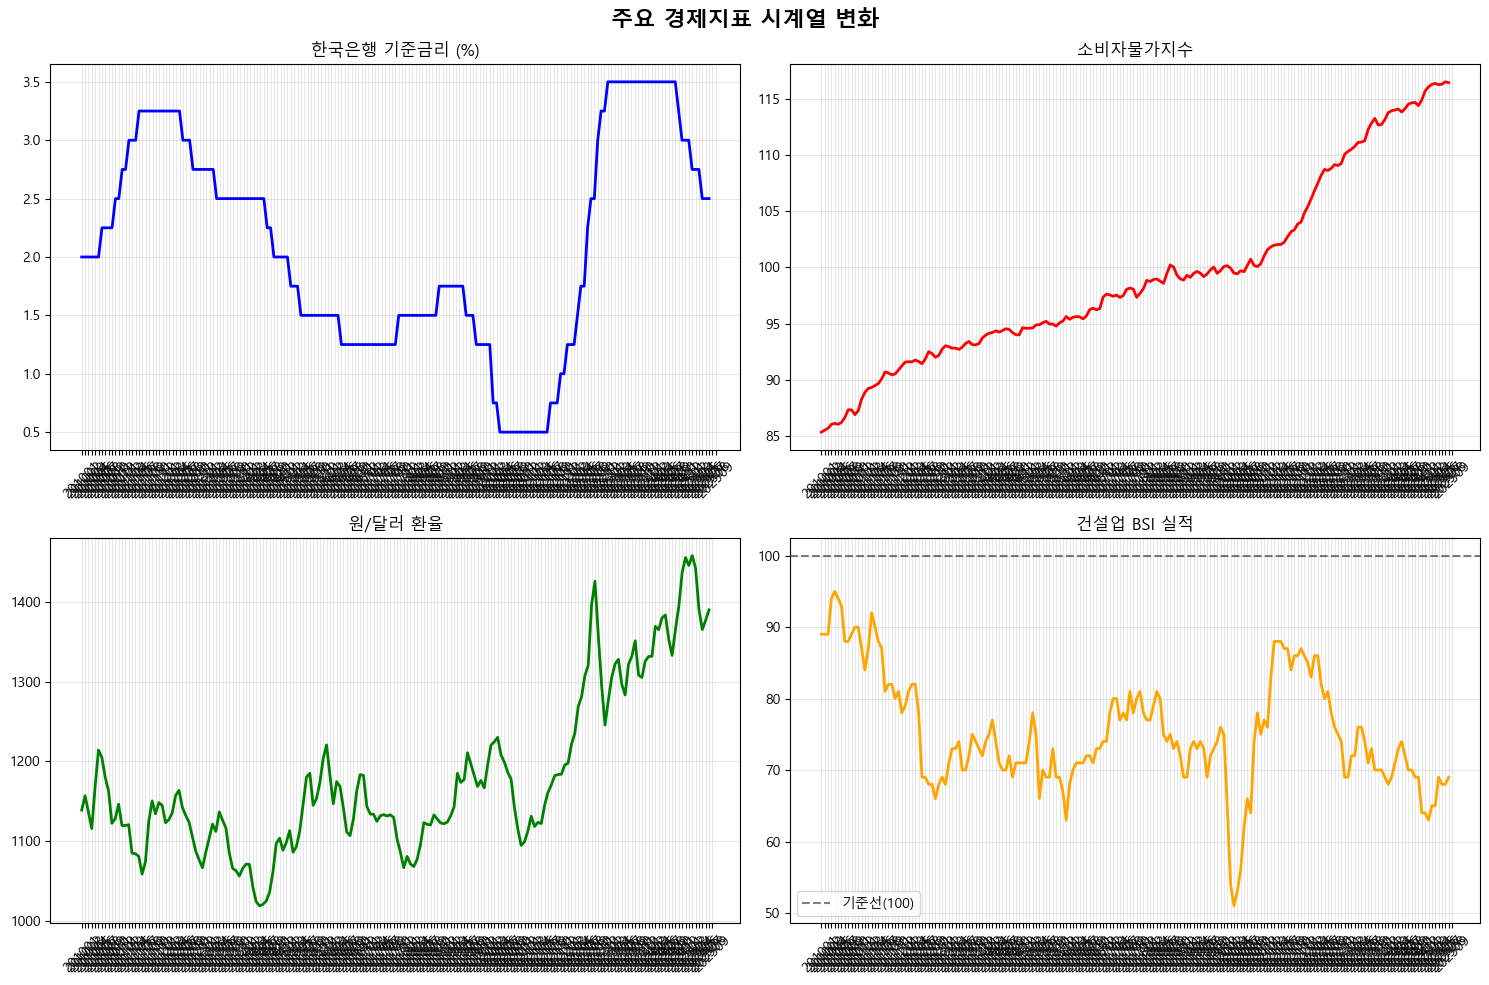

In [33]:
# 1. 주요 경제지표 시계열 그래프
if 'ecos_data' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('주요 경제지표 시계열 변화', fontsize=16, fontweight='bold')
    
    # 1) 기준금리
    axes[0, 0].plot(ecos_data['date'], ecos_data['base_rate'], color='blue', linewidth=2)
    axes[0, 0].set_title('한국은행 기준금리 (%)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2) 소비자물가지수
    axes[0, 1].plot(ecos_data['date'], ecos_data['cpi'], color='red', linewidth=2)
    axes[0, 1].set_title('소비자물가지수')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3) 원달러 환율
    axes[1, 0].plot(ecos_data['date'], ecos_data['exchange_usd_krw_close'], color='green', linewidth=2)
    axes[1, 0].set_title('원/달러 환율')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4) 건설업 BSI 실적
    axes[1, 1].plot(ecos_data['date'], ecos_data['construction_bsi_actual'], color='orange', linewidth=2)
    axes[1, 1].set_title('건설업 BSI 실적')
    axes[1, 1].axhline(y=100, color='black', linestyle='--', alpha=0.5, label='기준선(100)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("ECOS 데이터가 없습니다. 이전 셀을 먼저 실행해주세요.")

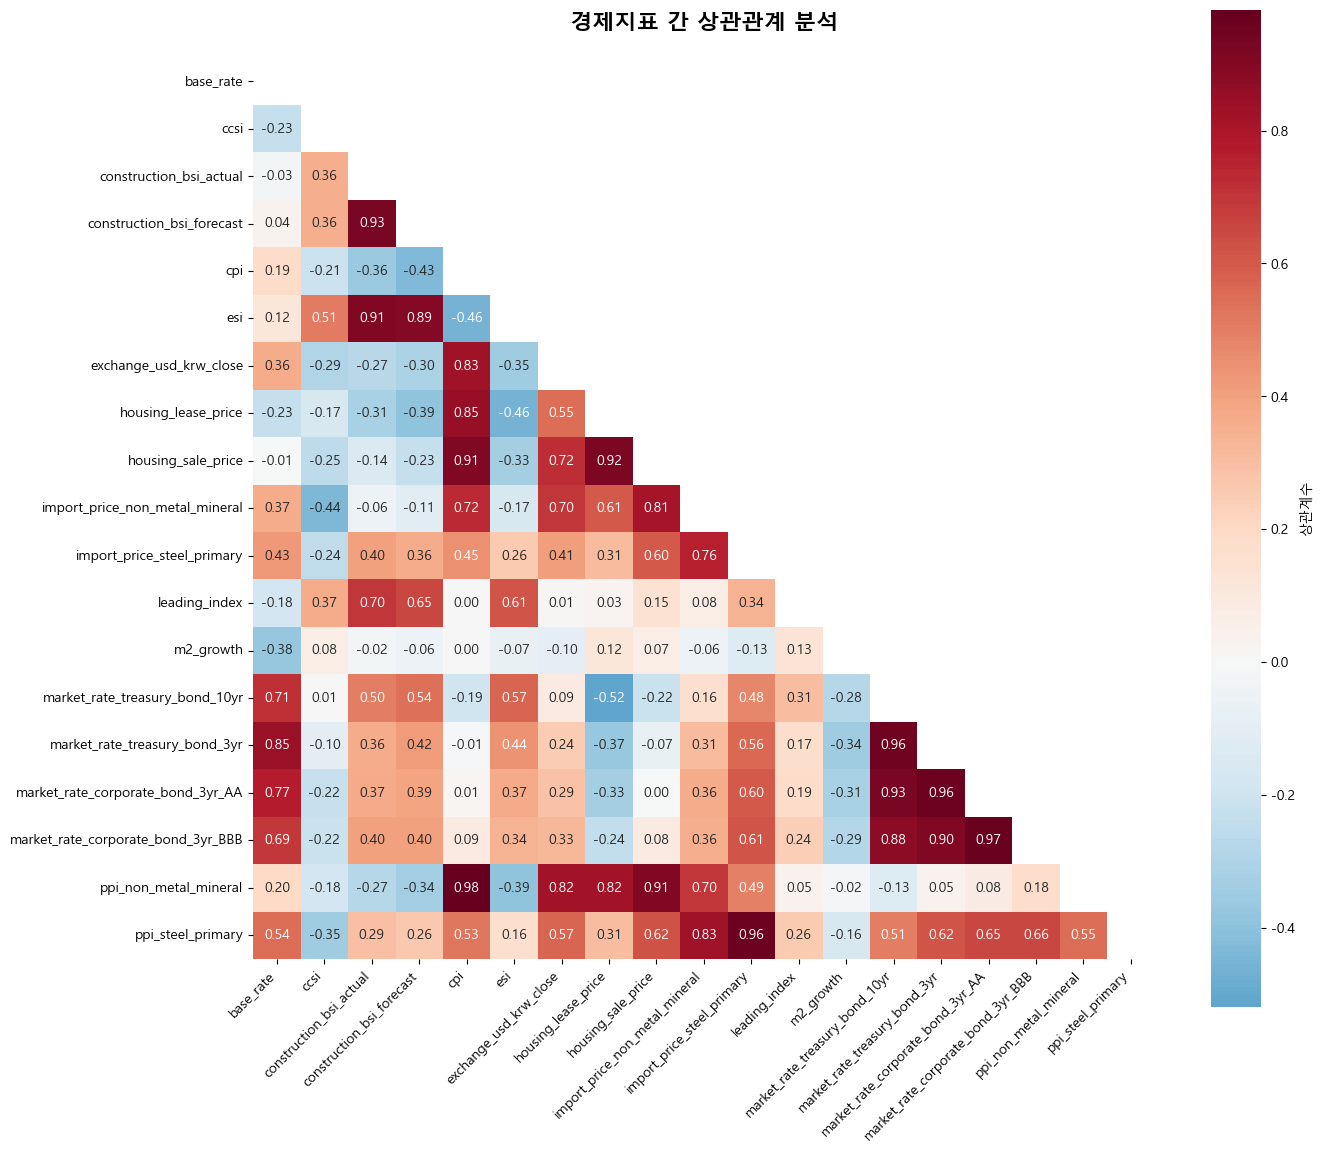

=== 건설업 BSI 실적과의 상관관계 ===
construction_bsi_actual               1.000000
construction_bsi_forecast             0.932074
esi                                   0.905431
leading_index                         0.699616
market_rate_treasury_bond_10yr        0.497952
import_price_steel_primary            0.401252
market_rate_corporate_bond_3yr_BBB    0.400306
market_rate_corporate_bond_3yr_AA     0.371168
cpi                                   0.363448
market_rate_treasury_bond_3yr         0.362326
Name: construction_bsi_actual, dtype: float64


In [37]:
import seaborn as sns

# 2. 경제지표 간 상관관계 히트맵
if 'ecos_data' in locals():
    # 수치형 컬럼만 선택 (날짜 제외)
    numeric_cols = ecos_data.select_dtypes(include=[np.number]).columns
    correlation_matrix = ecos_data[numeric_cols].corr()
    
    plt.figure(figsize=(14, 12))
    
    # 히트맵 생성
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # 상삼각 마스크
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={'label': '상관계수'})
    
    plt.title('경제지표 간 상관관계 분석', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # 건설업 BSI와 높은 상관관계를 가진 지표들
    print("=== 건설업 BSI 실적과의 상관관계 ===")
    bsi_corr = correlation_matrix['construction_bsi_actual'].abs().sort_values(ascending=False)
    print(bsi_corr.head(10))

In [38]:
# ECOS 월간 데이터 준비 및 정리
print("=== ECOS 월간 데이터 처리 ===")

# 1. 월간 데이터 복사 및 날짜 처리
ecos_monthly = ecos_data.copy()

# 날짜 컬럼을 YYYY-MM 형식으로 처리
if ecos_monthly['date'].dtype == 'object' or ecos_monthly['date'].dtype == 'int64':
    # YYYYMM 형식을 YYYY-MM 문자열로 변환
    ecos_monthly['date'] = ecos_monthly['date'].astype(str).str[:4] + '-' + ecos_monthly['date'].astype(str).str[4:6]
else:
    # datetime 형식인 경우 YYYY-MM 문자열로 변환
    ecos_monthly['date'] = ecos_monthly['date'].dt.strftime('%Y-%m')

ecos_monthly = ecos_monthly.sort_values('date').reset_index(drop=True)

# 현재 달 데이터 제거 (2025-09)
current_month = "2025-09"
print(f"현재 달 데이터 제거: {current_month}")
initial_count = len(ecos_monthly)
ecos_monthly = ecos_monthly[ecos_monthly['date'] != current_month].reset_index(drop=True)
removed_count = initial_count - len(ecos_monthly)
print(f"제거된 데이터: {removed_count}개")

print(f"월간 데이터 기간: {ecos_monthly['date'].min()} ~ {ecos_monthly['date'].max()}")
print(f"월간 데이터 개수: {len(ecos_monthly)}개")

# 2. 월간 파생변수 생성
print("\n=== 월간 파생변수 생성 ===")

# 2-1. CPI MoM (Month over Month) 변화율
ecos_monthly['cpi_mom'] = ecos_monthly['cpi'].pct_change() * 100  # 백분율로 변환

# 2-2. 기준금리 월별 변화폭 (bp, basis points)
ecos_monthly['base_rate_mdiff_bp'] = ecos_monthly['base_rate'].diff() * 100  # bp로 변환

# 2-3. Term Spread (10Y - 3Y 국고채 금리차)
ecos_monthly['term_spread'] = ecos_monthly['market_rate_treasury_bond_10yr'] - ecos_monthly['market_rate_treasury_bond_3yr']

# 2-4. Credit Spread (BBB - AA 회사채 금리차)
ecos_monthly['credit_spread'] = ecos_monthly['market_rate_corporate_bond_3yr_BBB'] - ecos_monthly['market_rate_corporate_bond_3yr_AA']

# 2-5. 환율 3개월 이동평균
ecos_monthly['exchange_ma3'] = ecos_monthly['exchange_usd_krw_close'].rolling(window=3, min_periods=1).mean()

# 2-6. 환율 전월 대비 변화율
ecos_monthly['exchange_mom'] = ecos_monthly['exchange_usd_krw_close'].pct_change() * 100

# 2-7. 건설업 BSI 3개월 이동평균
ecos_monthly['construction_bsi_ma3'] = ecos_monthly['construction_bsi_actual'].rolling(window=3, min_periods=1).mean()

# 2-8. 건설업 BSI 전월 대비 변화
ecos_monthly['construction_bsi_mom'] = ecos_monthly['construction_bsi_actual'].diff()

# 3. 첫 번째 행의 NaN 제거 (변화율 계산으로 인한)
print(f"파생변수 생성 전: {len(ecos_monthly)}개")
ecos_monthly = ecos_monthly.dropna(subset=['cpi_mom']).reset_index(drop=True)
print(f"파생변수 생성 후: {len(ecos_monthly)}개")

# 4. 컬럼 순서 정리
# 시간 관련 컬럼
time_cols = ['date']

# 모든 파생변수 리스트
monthly_derived_vars = ['cpi_mom', 'base_rate_mdiff_bp', 'term_spread', 'credit_spread', 
                       'exchange_ma3', 'exchange_mom', 'construction_bsi_ma3', 'construction_bsi_mom']

# 원본 경제지표 컬럼들 (파생변수와 시간 컬럼, id 제외)
original_cols = [col for col in ecos_monthly.columns 
                if col not in time_cols + monthly_derived_vars + ['id', 'created_at', 'updated_at']]

# 컬럼 순서: 지표와 관련 파생변수를 그룹으로 배치
column_order = time_cols.copy()

# 기준금리 그룹
if 'base_rate' in original_cols:
    column_order.append('base_rate')
    if 'base_rate_mdiff_bp' in ecos_monthly.columns:
        column_order.append('base_rate_mdiff_bp')
    original_cols.remove('base_rate')

# CPI 그룹  
if 'cpi' in original_cols:
    column_order.append('cpi')
    if 'cpi_mom' in ecos_monthly.columns:
        column_order.append('cpi_mom')
    original_cols.remove('cpi')

# 건설업 BSI 그룹
if 'construction_bsi_actual' in original_cols:
    column_order.append('construction_bsi_actual')
    if 'construction_bsi_ma3' in ecos_monthly.columns:
        column_order.append('construction_bsi_ma3')
    if 'construction_bsi_mom' in ecos_monthly.columns:
        column_order.append('construction_bsi_mom')
    original_cols.remove('construction_bsi_actual')

# 환율 그룹
if 'exchange_usd_krw_close' in original_cols:
    column_order.append('exchange_usd_krw_close')
    if 'exchange_mom' in ecos_monthly.columns:
        column_order.append('exchange_mom')
    if 'exchange_ma3' in ecos_monthly.columns:
        column_order.append('exchange_ma3')
    original_cols.remove('exchange_usd_krw_close')

# 국고채 그룹
if 'market_rate_treasury_bond_3yr' in original_cols:
    column_order.append('market_rate_treasury_bond_3yr')
    original_cols.remove('market_rate_treasury_bond_3yr')

if 'market_rate_treasury_bond_10yr' in original_cols:
    column_order.append('market_rate_treasury_bond_10yr')
    original_cols.remove('market_rate_treasury_bond_10yr')

# Term Spread
if 'term_spread' in ecos_monthly.columns:
    column_order.append('term_spread')

# 회사채 그룹
if 'market_rate_corporate_bond_3yr_AA' in original_cols:
    column_order.append('market_rate_corporate_bond_3yr_AA')
    original_cols.remove('market_rate_corporate_bond_3yr_AA')

if 'market_rate_corporate_bond_3yr_BBB' in original_cols:
    column_order.append('market_rate_corporate_bond_3yr_BBB')
    original_cols.remove('market_rate_corporate_bond_3yr_BBB')

# Credit Spread
if 'credit_spread' in ecos_monthly.columns:
    column_order.append('credit_spread')

# 나머지 원본 경제지표들 (알파벳 순서)
remaining_cols = sorted(original_cols)
column_order.extend(remaining_cols)

# 실제 존재하는 컬럼만 선택
final_columns = [col for col in column_order if col in ecos_monthly.columns]
ecos_monthly = ecos_monthly[final_columns]

print("\n=== 월간 파생변수 요약 통계 ===")
print(ecos_monthly[monthly_derived_vars].describe().round(2))

print(f"\n=== 최종 월간 데이터 컬럼 ===")
print(f"총 컬럼 수: {len(ecos_monthly.columns)}")
print("컬럼 목록:")
for i, col in enumerate(ecos_monthly.columns):
    print(f"  {i+1}. {col}")

print("\n=== 최근 5개월 데이터 ===")
recent_monthly_cols = ['date', 'construction_bsi_actual', 'construction_bsi_ma3', 'cpi_mom', 'base_rate_mdiff_bp', 'exchange_mom']
print(ecos_monthly[recent_monthly_cols].tail())

=== ECOS 월간 데이터 처리 ===
현재 달 데이터 제거: 2025-09
제거된 데이터: 1개
월간 데이터 기간: 2010-01 ~ 2025-08
월간 데이터 개수: 188개

=== 월간 파생변수 생성 ===
파생변수 생성 전: 188개
파생변수 생성 후: 187개

=== 월간 파생변수 요약 통계 ===
       cpi_mom  base_rate_mdiff_bp  term_spread  credit_spread  exchange_ma3  \
count   187.00              186.00       187.00         187.00        187.00   
mean      0.17                0.27         0.42           6.00       1177.04   
std       0.33               11.91         0.27           0.25         99.98   
min      -0.74              -50.00        -0.09           5.38       1021.10   
25%      -0.07                0.00         0.22           5.83       1114.71   
50%       0.17                0.00         0.40           6.04       1143.90   
75%       0.38                0.00         0.56           6.21       1200.90   
max       1.19               50.00         1.25           6.45       1453.00   

       exchange_mom  construction_bsi_ma3  construction_bsi_mom  
count        187.00                18

In [39]:
ecos_monthly

,date,base_rate,base_rate_mdiff_bp,cpi,cpi_mom,construction_bsi_actual,construction_bsi_ma3,construction_bsi_mom,exchange_usd_krw_close,exchange_mom,...,construction_bsi_forecast,esi,housing_lease_price,housing_sale_price,import_price_non_metal_mineral,import_price_steel_primary,leading_index,m2_growth,ppi_non_metal_mineral,ppi_steel_primary
0,2010-02,2.00,0.0,85.523,0.201521,89.0,89.000000,0.0,1156.83,1.585922,...,90.0,117.3,58.872,65.040,73.47,104.28,102.4,1.26,79.42,100.22
1,2010-03,2.00,0.0,85.696,0.202285,89.0,89.000000,0.0,1136.11,-1.791102,...,96.0,116.1,59.271,65.201,73.47,108.21,102.1,0.93,79.42,100.84
2,2010-04,2.00,0.0,86.041,0.402586,94.0,90.666667,5.0,1115.71,-1.795601,...,94.0,117.5,59.643,65.327,73.47,116.42,101.9,0.91,78.93,103.77
3,2010-05,2.00,0.0,86.128,0.101115,95.0,92.666667,1.0,1168.41,4.723450,...,98.0,116.8,59.886,65.358,78.92,116.76,102.0,0.39,78.93,112.46
4,2010-06,2.00,0.0,86.041,-0.101012,94.0,94.333333,-1.0,1214.02,3.903595,...,95.0,115.5,60.123,65.365,74.12,114.22,102.0,1.04,79.14,115.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2025-04,2.75,0.0,116.380,0.077393,65.0,64.333333,0.0,1441.92,-1.097454,...,65.0,87.5,93.371,92.994,146.60,119.97,100.8,0.19,128.25,131.66
183,2025-05,2.50,-25.0,116.270,-0.094518,69.0,66.333333,4.0,1390.70,-3.552208,...,65.0,92.2,93.414,93.038,146.60,119.42,100.8,1.05,128.17,131.52
184,2025-06,2.50,0.0,116.310,0.034403,68.0,67.333333,-1.0,1365.15,-1.837204,...,69.0,92.8,93.483,93.164,143.66,118.61,101.0,0.63,127.15,131.65
185,2025-07,2.50,0.0,116.520,0.180552,68.0,68.333333,0.0,1376.92,0.862176,...,68.0,92.9,93.555,93.317,143.66,116.49,101.5,1.00,126.68,131.22


In [40]:
# ECOS 월간 데이터 결측치 처리 및 보간
print("=== ECOS 월간 데이터 결측치 분석 및 보간 ===")

# 1. 결측치 현황 분석
print("\n1. 결측치 현황 분석")
missing_info = ecos_monthly.isnull().sum()
missing_info = missing_info[missing_info > 0].sort_values(ascending=False)

if len(missing_info) > 0:
    print(f"결측치가 있는 컬럼: {len(missing_info)}개")
    print("결측치 개수:")
    for col, count in missing_info.items():
        pct = (count / len(ecos_monthly)) * 100
        print(f"  {col}: {count}개 ({pct:.1f}%)")
    
    # 2. 결측치 패턴 분석
    print(f"\n2. 결측치 패턴 분석")
    
    # 날짜별 결측치 현황
    missing_by_date = ecos_monthly[missing_info.index].isnull().sum(axis=1)
    dates_with_missing = ecos_monthly[missing_by_date > 0]['date'].tolist()
    if dates_with_missing:
        print(f"결측치가 있는 날짜: {len(dates_with_missing)}개")
        print(f"최초 결측치 날짜: {min(dates_with_missing)}")
        print(f"최근 결측치 날짜: {max(dates_with_missing)}")
    
    # 3. 결측치 보간
    print(f"\n3. 결측치 보간 실행")
    ecos_monthly_filled = ecos_monthly.copy()
    
    # 수치형 컬럼만 선택 (date 제외)
    numeric_cols_for_interpolation = [col for col in ecos_monthly.columns 
                                    if col != 'date' and ecos_monthly[col].dtype in ['float64', 'int64']]
    
    for col in missing_info.index:
        if col in numeric_cols_for_interpolation:
            print(f"  {col} 보간 중...")
            
            # 선형 보간 적용
            ecos_monthly_filled[col] = ecos_monthly_filled[col].interpolate(method='linear')
            
            # 앞뒤 결측치는 forward fill과 backward fill로 처리
            ecos_monthly_filled[col] = ecos_monthly_filled[col].fillna(method='ffill').fillna(method='bfill')
    
    # 4. 보간 결과 확인
    print(f"\n4. 보간 결과 확인")
    remaining_missing = ecos_monthly_filled.isnull().sum().sum()
    print(f"보간 후 전체 결측치: {remaining_missing}개")
    
    if remaining_missing == 0:
        print("모든 결측치가 성공적으로 보간되었습니다.")
        ecos_monthly = ecos_monthly_filled.copy()
    else:
        remaining_missing_cols = ecos_monthly_filled.isnull().sum()
        remaining_missing_cols = remaining_missing_cols[remaining_missing_cols > 0]
        print(f"보간되지 않은 결측치:")
        for col, count in remaining_missing_cols.items():
            print(f"  {col}: {count}개")
        
        # 남은 결측치는 평균값으로 대체
        for col in remaining_missing_cols.index:
            if col in numeric_cols_for_interpolation:
                mean_val = ecos_monthly_filled[col].mean()
                ecos_monthly_filled[col] = ecos_monthly_filled[col].fillna(mean_val)
                print(f"  {col}: 평균값({mean_val:.2f})으로 대체")
        
        ecos_monthly = ecos_monthly_filled.copy()
        print("모든 결측치가 처리되었습니다.")
    
    # 5. 처리 결과 요약
    print(f"\n5. 최종 데이터 확인")
    print(f"데이터 형태: {ecos_monthly.shape}")
    print(f"전체 결측치: {ecos_monthly.isnull().sum().sum()}개")
    print(f"데이터 기간: {ecos_monthly['date'].min()} ~ {ecos_monthly['date'].max()}")
    
else:
    print("결측치가 없습니다. 데이터가 완전합니다.")
    print(f"데이터 형태: {ecos_monthly.shape}")
    print(f"데이터 기간: {ecos_monthly['date'].min()} ~ {ecos_monthly['date'].max()}")

print("\n" + "="*50)
print("ECOS 월간 데이터 결측치 처리 완료")
print("="*50)

=== ECOS 월간 데이터 결측치 분석 및 보간 ===

1. 결측치 현황 분석
결측치가 있는 컬럼: 6개
결측치 개수:
  base_rate: 1개 (0.5%)
  base_rate_mdiff_bp: 1개 (0.5%)
  leading_index: 1개 (0.5%)
  m2_growth: 1개 (0.5%)
  ppi_non_metal_mineral: 1개 (0.5%)
  ppi_steel_primary: 1개 (0.5%)

2. 결측치 패턴 분석
결측치가 있는 날짜: 1개
최초 결측치 날짜: 2025-08
최근 결측치 날짜: 2025-08

3. 결측치 보간 실행
  base_rate 보간 중...
  base_rate_mdiff_bp 보간 중...
  leading_index 보간 중...
  m2_growth 보간 중...
  ppi_non_metal_mineral 보간 중...
  ppi_steel_primary 보간 중...

4. 보간 결과 확인
보간 후 전체 결측치: 0개
모든 결측치가 성공적으로 보간되었습니다.

5. 최종 데이터 확인
데이터 형태: (187, 28)
전체 결측치: 0개
데이터 기간: 2010-02 ~ 2025-08

ECOS 월간 데이터 결측치 처리 완료


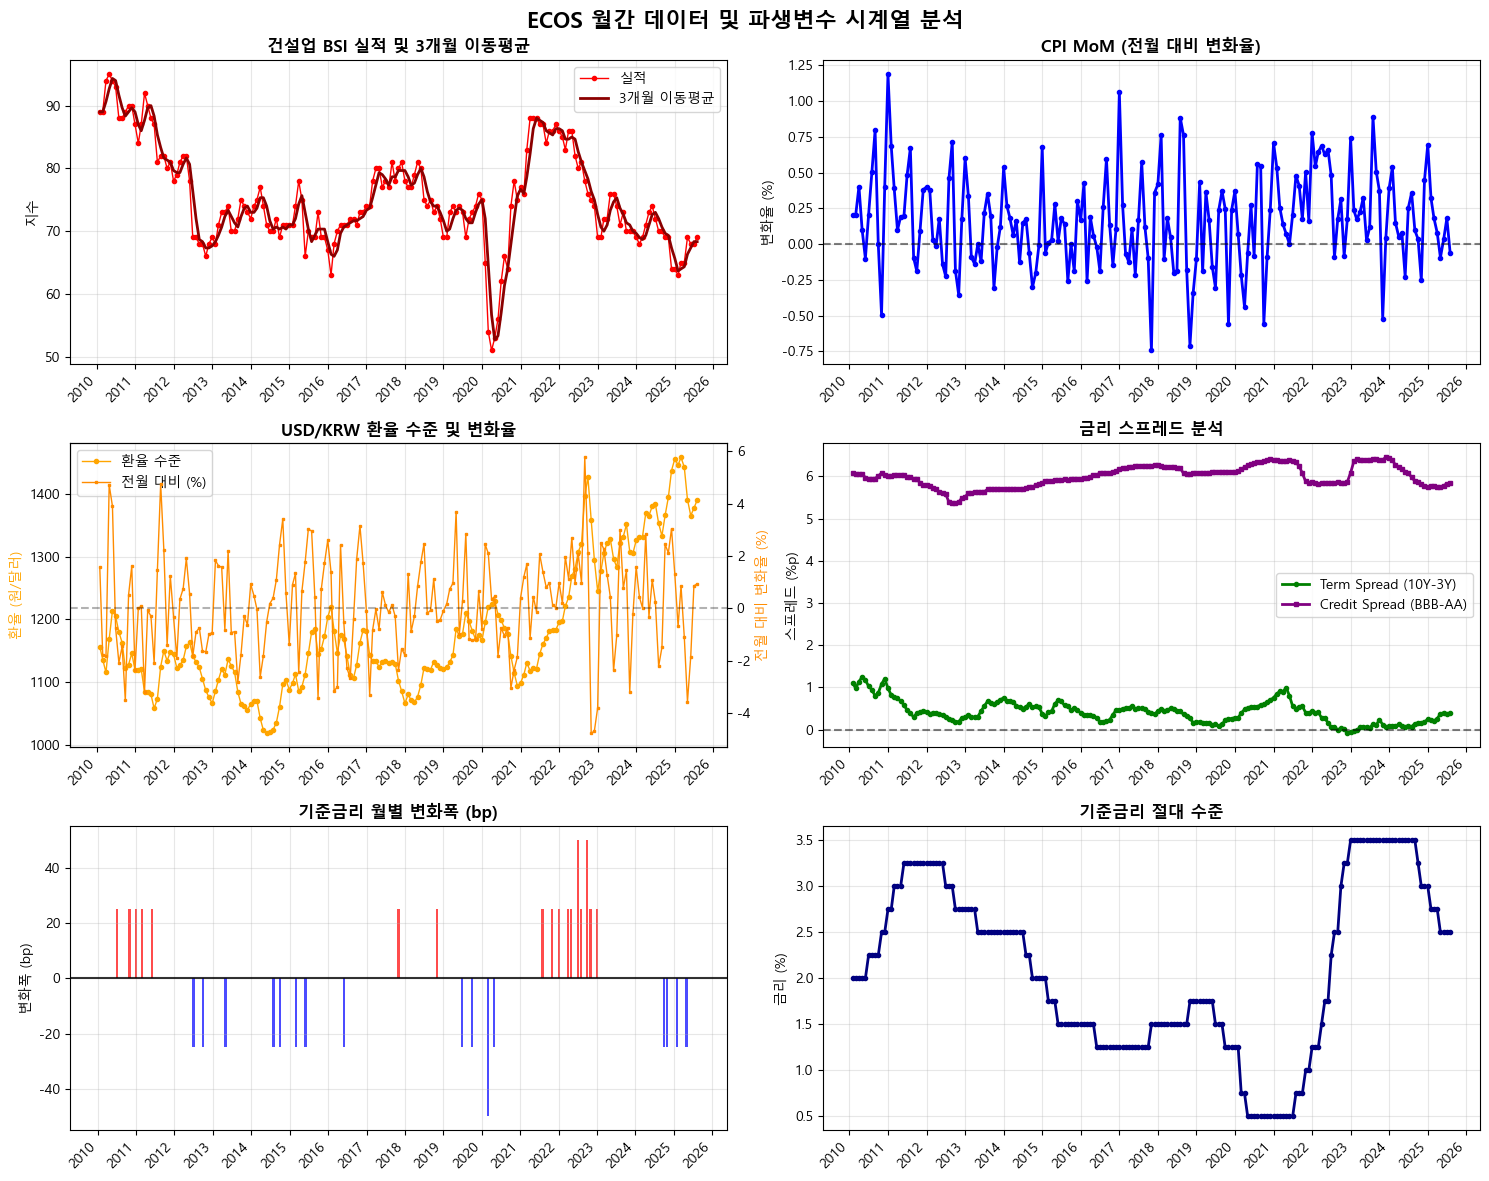


=== 월간 파생변수 간 상관관계 ===
                      cpi_mom  base_rate_mdiff_bp  term_spread  credit_spread  \
cpi_mom                 1.000               0.206        0.052          0.035   
base_rate_mdiff_bp      0.206               1.000        0.024          0.065   
term_spread             0.052               0.024        1.000          0.016   
credit_spread           0.035               0.065        0.016          1.000   
exchange_ma3            0.063               0.053       -0.513          0.146   
exchange_mom            0.043              -0.024       -0.024          0.021   
construction_bsi_ma3    0.209               0.385        0.480          0.055   
construction_bsi_mom   -0.136               0.105        0.116          0.127   

                      exchange_ma3  exchange_mom  construction_bsi_ma3  \
cpi_mom                      0.063         0.043                 0.209   
base_rate_mdiff_bp           0.053        -0.024                 0.385   
term_spread             

In [41]:
# 월간 데이터 및 파생변수 시각화
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 시각화를 위한 datetime 컬럼 생성 (원본 date는 YYYY-MM 문자열 유지)
ecos_monthly['date_for_plot'] = pd.to_datetime(ecos_monthly['date'] + '-01')

# 주요 월간 파생변수 시각화
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('ECOS 월간 데이터 및 파생변수 시계열 분석', fontsize=16, fontweight='bold')

# 1. 건설업 BSI 실적 및 이동평균
axes[0,0].plot(ecos_monthly['date_for_plot'], ecos_monthly['construction_bsi_actual'], 'o-', color='red', linewidth=1, markersize=3, label='실적')
axes[0,0].plot(ecos_monthly['date_for_plot'], ecos_monthly['construction_bsi_ma3'], '-', color='darkred', linewidth=2, label='3개월 이동평균')
axes[0,0].set_title('건설업 BSI 실적 및 3개월 이동평균', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('지수')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

# 2. CPI MoM 변화율
axes[0,1].plot(ecos_monthly['date_for_plot'], ecos_monthly['cpi_mom'], 'o-', color='blue', linewidth=2, markersize=3)
axes[0,1].set_title('CPI MoM (전월 대비 변화율)', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('변화율 (%)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 3. 환율 및 변화율
ax3 = axes[1,0]
ax3_twin = ax3.twinx()
line1 = ax3.plot(ecos_monthly['date_for_plot'], ecos_monthly['exchange_usd_krw_close'], 'o-', color='orange', linewidth=1, markersize=3, label='환율 수준')
line2 = ax3_twin.plot(ecos_monthly['date_for_plot'], ecos_monthly['exchange_mom'], 's-', color='darkorange', linewidth=1, markersize=2, label='전월 대비 (%)')
ax3.set_title('USD/KRW 환율 수준 및 변화율', fontsize=12, fontweight='bold')
ax3.set_ylabel('환율 (원/달러)', color='orange')
ax3_twin.set_ylabel('전월 대비 변화율 (%)', color='darkorange')
ax3.grid(True, alpha=0.3)
ax3_twin.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# 범례 결합
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 4. Term Spread & Credit Spread
axes[1,1].plot(ecos_monthly['date_for_plot'], ecos_monthly['term_spread'], 'o-', color='green', linewidth=2, markersize=3, label='Term Spread (10Y-3Y)')
axes[1,1].plot(ecos_monthly['date_for_plot'], ecos_monthly['credit_spread'], 's-', color='purple', linewidth=2, markersize=3, label='Credit Spread (BBB-AA)')
axes[1,1].set_title('금리 스프레드 분석', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('스프레드 (%p)')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()
axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 5. 기준금리 변화폭
axes[2,0].bar(ecos_monthly['date_for_plot'], ecos_monthly['base_rate_mdiff_bp'], 
              color=['red' if x > 0 else 'blue' for x in ecos_monthly['base_rate_mdiff_bp']], alpha=0.7, width=20)
axes[2,0].set_title('기준금리 월별 변화폭 (bp)', fontsize=12, fontweight='bold')
axes[2,0].set_ylabel('변화폭 (bp)')
axes[2,0].grid(True, alpha=0.3)
axes[2,0].axhline(y=0, color='black', linestyle='-', alpha=0.8)

# 6. 기준금리 절대수준
axes[2,1].plot(ecos_monthly['date_for_plot'], ecos_monthly['base_rate'], 'o-', color='navy', linewidth=2, markersize=3)
axes[2,1].set_title('기준금리 절대 수준', fontsize=12, fontweight='bold')
axes[2,1].set_ylabel('금리 (%)')
axes[2,1].grid(True, alpha=0.3)

# X축 날짜 포맷팅
for ax in axes.flat:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 시각화 완료 후 임시 컬럼 제거
ecos_monthly = ecos_monthly.drop(columns=['date_for_plot'])

# 월간 파생변수 간 상관관계 분석
print("\n=== 월간 파생변수 간 상관관계 ===")
available_derived_vars = [col for col in monthly_derived_vars if col in ecos_monthly.columns]
correlation_matrix = ecos_monthly[available_derived_vars].corr()
print(correlation_matrix.round(3))

# 건설업 BSI와 다른 파생변수들의 상관관계
print("\n=== 건설업 BSI 실적과 파생변수들의 상관관계 ===")
bsi_correlation = ecos_monthly[available_derived_vars + ['construction_bsi_actual']].corr()['construction_bsi_actual'].abs().sort_values(ascending=False)
print(bsi_correlation.head(10).round(3))

print("\n=== 최종 월간 데이터 요약 ===")
print(f"데이터 기간: {ecos_monthly['date'].min()} ~ {ecos_monthly['date'].max()}")
print(f"총 데이터 포인트: {len(ecos_monthly)}개")
print(f"총 변수(컬럼): {len(ecos_monthly.columns)}개")
print(f"파생변수: {len(available_derived_vars)}개")

In [42]:
ecos_monthly

,date,base_rate,base_rate_mdiff_bp,cpi,cpi_mom,construction_bsi_actual,construction_bsi_ma3,construction_bsi_mom,exchange_usd_krw_close,exchange_mom,...,construction_bsi_forecast,esi,housing_lease_price,housing_sale_price,import_price_non_metal_mineral,import_price_steel_primary,leading_index,m2_growth,ppi_non_metal_mineral,ppi_steel_primary
0,2010-02,2.00,0.0,85.523,0.201521,89.0,89.000000,0.0,1156.83,1.585922,...,90.0,117.3,58.872,65.040,73.47,104.28,102.4,1.26,79.42,100.22
1,2010-03,2.00,0.0,85.696,0.202285,89.0,89.000000,0.0,1136.11,-1.791102,...,96.0,116.1,59.271,65.201,73.47,108.21,102.1,0.93,79.42,100.84
2,2010-04,2.00,0.0,86.041,0.402586,94.0,90.666667,5.0,1115.71,-1.795601,...,94.0,117.5,59.643,65.327,73.47,116.42,101.9,0.91,78.93,103.77
3,2010-05,2.00,0.0,86.128,0.101115,95.0,92.666667,1.0,1168.41,4.723450,...,98.0,116.8,59.886,65.358,78.92,116.76,102.0,0.39,78.93,112.46
4,2010-06,2.00,0.0,86.041,-0.101012,94.0,94.333333,-1.0,1214.02,3.903595,...,95.0,115.5,60.123,65.365,74.12,114.22,102.0,1.04,79.14,115.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2025-04,2.75,0.0,116.380,0.077393,65.0,64.333333,0.0,1441.92,-1.097454,...,65.0,87.5,93.371,92.994,146.60,119.97,100.8,0.19,128.25,131.66
183,2025-05,2.50,-25.0,116.270,-0.094518,69.0,66.333333,4.0,1390.70,-3.552208,...,65.0,92.2,93.414,93.038,146.60,119.42,100.8,1.05,128.17,131.52
184,2025-06,2.50,0.0,116.310,0.034403,68.0,67.333333,-1.0,1365.15,-1.837204,...,69.0,92.8,93.483,93.164,143.66,118.61,101.0,0.63,127.15,131.65
185,2025-07,2.50,0.0,116.520,0.180552,68.0,68.333333,0.0,1376.92,0.862176,...,68.0,92.9,93.555,93.317,143.66,116.49,101.5,1.00,126.68,131.22


In [43]:
pd.DataFrame.to_csv(ecos_monthly, 'ecos_monthly_data.csv', index=False)

## ECOS 데이터 스케일링

데이터 분할 이후 수행

In [ ]:
'''# StandardScaler를 사용한 월별 데이터 스케일링
from sklearn.preprocessing import StandardScaler
import pandas as pd

if 'ecos_monthly' in locals():
    print("=== ECOS 월별 데이터 스케일링 ===")
    
    # date_yyyymm 컬럼 분리
    date_yyyymm_col = ecos_monthly['date_yyyymm'].copy()
    
    # 수치형 컬럼만 선택 (date_yyyymm 제외)
    numeric_cols = [col for col in ecos_monthly.columns if col != 'date_yyyymm']
    numeric_data = ecos_monthly[numeric_cols].copy()
    
    print(f"스케일링 대상 컬럼: {len(numeric_cols)}개")
    print(f"컬럼명: {list(numeric_cols)}")
    
    # 결측값 확인
    print(f"\n결측값 현황:")
    missing_counts = numeric_data.isnull().sum()
    print(missing_counts[missing_counts > 0])
    
    # 결측값이 있다면 처리 (forward fill 사용)
    if numeric_data.isnull().any().any():
        print("결측값 처리 중...")
        numeric_data = numeric_data.fillna(method='ffill').fillna(method='bfill')
        print("결측값 처리 완료")
    
    # 스케일링 전 통계
    print(f"\n스케일링 전 데이터 통계:")
    print(numeric_data.describe().round(2))
    
    # StandardScaler 적용
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_data)
    
    # 스케일링된 데이터를 DataFrame으로 변환
    ecos_scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols, index=numeric_data.index)
    
    # date_yyyymm 컬럼 추가
    ecos_scaled_df.insert(0, 'date_yyyymm', date_yyyymm_col)
    
    print(f"\n스케일링 후 데이터 통계:")
    scaled_numeric_cols = [col for col in ecos_scaled_df.columns if col != 'date_yyyymm']
    print(ecos_scaled_df[scaled_numeric_cols].describe().round(2))
    
    print(f"\n최종 스케일링된 데이터 형태: {ecos_scaled_df.shape}")
    print("스케일링된 데이터를 'ecos_scaled_df' 변수에 저장했습니다.")
    
    # 최종 결과 확인
    print("\n최종 처리된 ECOS 월별 데이터 샘플:")
    print(ecos_scaled_df.head(10))
    
else:
    print("ecos_monthly 변수가 없습니다. 이전 셀을 먼저 실행해주세요.")'''

In [ ]:
'''# ECOS 최종 데이터 저장
if 'ecos_monthly' in locals():
    # CSV 파일로 저장
    ecos_monthly.to_csv('ecos_monthly_final.csv', index=False)
    print("ECOS 월별 데이터 저장 완료: ecos_monthly_final.csv")
    print(f"저장된 데이터 형태: {ecos_monthly.shape}")
    print(f"데이터 기간: {ecos_monthly['date_yyyymm'].min()} ~ {ecos_monthly['date_yyyymm'].max()}")
    
    # 변수 요약
    print(f"\n최종 변수 목록 ({len(ecos_monthly.columns)}개):")
    for i, col in enumerate(ecos_monthly.columns, 1):
        print(f"  {i:2d}. {col}")
    
else:
    print("ecos_monthly 변수를 찾을 수 없습니다. 이전 셀들을 실행해주세요.")

print("\n" + "="*50)
print("ECOS 데이터 전처리 완료!")
print("="*50)'''

# DART 건설업 재무데이터 전처리

DART에서 수집한 건설업 기업의 분기별 재무데이터를 전처리합니다.

**처리 결과**: dart_final (분기별 재무데이터)

---

In [45]:
# DART 재무데이터 전처리용 라이브러리
import pandas as pd
import numpy as np
import sys
import os
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler

# 프로젝트 루트 경로 설정
current_dir = os.path.dirname(os.path.abspath('preprocessing.ipynb'))
parent_dir = os.path.dirname(current_dir)
db_folder = os.path.join(parent_dir, 'DB')
sys.path.append(db_folder)

# 환경변수 로드
env_file_path = os.path.join(parent_dir, '.env')
load_dotenv(env_file_path)

# 데이터베이스 연결
try:
    from db_query import DatabaseConnection
    print("데이터베이스 모듈 로드 성공")
except ImportError as e:
    print(f"데이터베이스 모듈 로드 실패: {e}")
    DatabaseConnection = None

print("DART 재무데이터 전처리 환경 설정 완료")

데이터베이스 모듈 로드 성공
DART 재무데이터 전처리 환경 설정 완료


In [47]:
# DART 재무데이터 로드
try:
    # 데이터베이스 연결 확인
    if DatabaseConnection is None:
        raise Exception("데이터베이스 모듈을 사용할 수 없습니다.")
    
    db = DatabaseConnection()
    if not db.connect():
        raise Exception("데이터베이스 연결에 실패했습니다.")
    
    print("데이터베이스 연결 성공!")
    
    # DART 데이터 조회
    dart_data = db.get_dart_data()
    
    if dart_data is not None and not dart_data.empty:
        print(f"DART 데이터 로드 완료: {dart_data.shape}")
        
        # 불필요한 컬럼 제거
        columns_to_remove = ['created_at', 'updated_at', 'id']
        existing_remove_cols = [col for col in columns_to_remove if col in dart_data.columns]
        if existing_remove_cols:
            dart_data = dart_data.drop(columns=existing_remove_cols)
            print(f"불필요한 컬럼 제거: {existing_remove_cols}")
        
        # 컬럼명 매핑 (DB 컬럼명 → 처리용 컬럼명)
        column_mapping = {
            'total_assets': '자산총계',
            'total_liabilities': '부채총계', 
            'total_equity': '자본총계',
            'revenue': '매출액',
            'operating_profit': '영업이익',
            'quarterly_profit': '분기순이익'
        }
        dart_data = dart_data.rename(columns=column_mapping)
        
        # 수치형 컬럼 데이터 타입 변환
        exclude_cols = ['corp_name', 'quarter', 'date', 'corp_code', 'report_date']
        numeric_column_names = [col for col in dart_data.columns if col not in exclude_cols]
        
        for col in numeric_column_names:
            if dart_data[col].dtype == 'object':
                dart_data[col] = pd.to_numeric(dart_data[col], errors='coerce')
        
        print(f"데이터 기간: {dart_data['year'].min()}년 ~ {dart_data['year'].max()}년")
        print(f"포함 기업: {dart_data['corp_name'].nunique()}개사")
        
        # 데이터 미리보기
        print("\nDART 데이터 미리보기:")
        print(dart_data.head())
        
        # 기업별 데이터 개수
        print(f"\n기업별 데이터 개수:")
        corp_counts = dart_data['corp_name'].value_counts()
        for corp, count in corp_counts.head(10).items():
            print(f"  {corp}: {count}개")
        
        # 연결 해제
        db.disconnect()
        
    else:
        print("DART 데이터를 로드할 수 없습니다.")
        
except Exception as e:
    print(f"DART 데이터 로드 중 오류 발생: {e}")
    print("CSV 파일에서 로드를 시도합니다...")
    
    # CSV 파일에서 로드 시도
    try:
        dart_data = pd.read_csv('../dart/dart_out/dart_merged_data.csv')
        print(f"CSV에서 DART 데이터 로드 완료: {dart_data.shape}")
    except Exception as csv_error:
        print(f"CSV 파일 로드도 실패: {csv_error}")
        dart_data = None

MySQL 데이터베이스 연결 성공
데이터베이스 연결 성공!
DART 데이터 로드 완료: (1248, 11)
데이터 기간: 2015년 ~ 2025년
포함 기업: 32개사

DART 데이터 미리보기:
  corp_name corp_code  year quarter report_date          자산총계          부채총계  \
0     DL이앤씨   1524093  2015      Q4  2015-12-01  1.206489e+13  7.259125e+12   
1     DL이앤씨   1524093  2016      Q1  2016-03-01  1.233208e+13  7.389715e+12   
2     DL이앤씨   1524093  2016      Q2  2016-06-01  1.237828e+13  7.324959e+12   
3     DL이앤씨   1524093  2016      Q3  2016-09-01  1.218542e+13  7.042494e+12   
4     DL이앤씨   1524093  2016      Q4  2016-12-01  1.239151e+13  7.246135e+12   

           자본총계           매출액          영업이익         분기순이익  
0  4.805769e+12           NaN           NaN           NaN  
1  4.942363e+12  2.253709e+12  9.077587e+10  3.103707e+10  
2  5.053324e+12  2.563786e+12  1.361732e+11  1.197966e+11  
3  5.142928e+12  2.457364e+12  1.306544e+11  1.090875e+11  
4  5.145374e+12  2.578911e+12  6.178428e+10  3.327409e+10  

기업별 데이터 개수:
  DL이앤씨: 39개
  GS건설: 39개
  HDC현대산업개발: 39개


In [ ]:
'''# 데이터베이스 상태 직접 확인
try:
    if 'db' not in locals() or not hasattr(db, 'connection') or not db.connection:
        db = DatabaseConnection()
        db.connect()
    
    # 테이블 행 수 확인
    count_query = "SELECT COUNT(*) as total_rows FROM dart_data"
    count_result = db.execute_query(count_query)
    print(f"DART 테이블 총 행 수: {count_result.iloc[0]['total_rows']}")
    
    # 테이블 구조 확인
    desc_query = "DESCRIBE dart_data"
    desc_result = db.execute_query(desc_query)
    print(f"\nDART 테이블 구조:")
    print(desc_result)
    
    # 최근 10개 레코드 확인
    sample_query = "SELECT corp_name, year, quarter, revenue FROM dart_data ORDER BY id DESC LIMIT 10"
    sample_result = db.execute_query(sample_query)
    print(f"\n최근 10개 레코드:")
    print(sample_result)
    
    # 기업별 개수 확인
    corp_count_query = "SELECT corp_name, COUNT(*) as count FROM dart_data GROUP BY corp_name ORDER BY count DESC"
    corp_count_result = db.execute_query(corp_count_query)
    print(f"\n기업별 레코드 수:")
    print(corp_count_result.head(10))
    
except Exception as e:
    print(f"데이터베이스 직접 확인 중 오류: {e}")
    import traceback
    traceback.print_exc()'''

쿼리 실행 오류: MySQL Connection not available.
데이터베이스 직접 확인 중 오류: 'NoneType' object has no attribute 'iloc'


Traceback (most recent call last):
  File "C:\Users\baesh\AppData\Local\Temp\ipykernel_26260\511308253.py", line 10, in <module>
    print(f"DART 테이블 총 행 수: {count_result.iloc[0]['total_rows']}")
                                   ^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'iloc'


In [49]:
dart_data

,corp_name,corp_code,year,quarter,report_date,자산총계,부채총계,자본총계,매출액,영업이익,분기순이익
0,DL이앤씨,1524093,2015,Q4,2015-12-01,1.206489e+13,7.259125e+12,4.805769e+12,NaN,NaN,NaN
1,DL이앤씨,1524093,2016,Q1,2016-03-01,1.233208e+13,7.389715e+12,4.942363e+12,2.253709e+12,9.077587e+10,3.103707e+10
2,DL이앤씨,1524093,2016,Q2,2016-06-01,1.237828e+13,7.324959e+12,5.053324e+12,2.563786e+12,1.361732e+11,1.197966e+11
3,DL이앤씨,1524093,2016,Q3,2016-09-01,1.218542e+13,7.042494e+12,5.142928e+12,2.457364e+12,1.306544e+11,1.090875e+11
4,DL이앤씨,1524093,2016,Q4,2016-12-01,1.239151e+13,7.246135e+12,5.145374e+12,2.578911e+12,6.178428e+10,3.327409e+10
...,...,...,...,...,...,...,...,...,...,...,...
1243,효성중공업,1316245,2024,Q2,2024-06-01,5.066724e+12,3.811208e+12,1.255516e+12,1.193776e+12,6.265961e+10,2.820423e+10
1244,효성중공업,1316245,2024,Q3,2024-09-01,5.100602e+12,3.774763e+12,1.325839e+12,1.145185e+12,1.114241e+11,7.241692e+10
1245,효성중공업,1316245,2024,Q4,2024-12-01,6.218813e+12,4.163194e+12,2.055618e+12,1.571511e+12,1.322304e+11,9.607912e+10
1246,효성중공업,1316245,2025,Q1,2025-03-01,6.689856e+12,4.574591e+12,2.115265e+12,1.076135e+12,1.023871e+11,1.036293e+11


In [50]:
# DART 데이터 기본 정보 확인
if 'dart_data' in locals():
    print("=== DART 데이터 기본 정보 ===")
    print(f"데이터 형태: {dart_data.shape}")
    print(f"메모리 사용량: {dart_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    print("\n=== 데이터 타입 ===")
    print(dart_data.dtypes)

    print("\n=== 결측값 확인 ===")
    print(dart_data.isnull().sum())

    print("\n=== 수치형 컬럼 기본 통계 ===")
    print(dart_data.describe())

=== DART 데이터 기본 정보 ===
데이터 형태: (1248, 11)
메모리 사용량: 0.35 MB

=== 데이터 타입 ===
corp_name       object
corp_code       object
year             int64
quarter         object
report_date     object
자산총계           float64
부채총계           float64
자본총계           float64
매출액            float64
영업이익           float64
분기순이익          float64
dtype: object

=== 결측값 확인 ===
corp_name       0
corp_code       0
year            0
quarter         0
report_date     0
자산총계           42
부채총계           42
자본총계           42
매출액            75
영업이익           75
분기순이익          75
dtype: int64

=== 수치형 컬럼 기본 통계 ===
              year          자산총계          부채총계          자본총계           매출액  \
count  1248.000000  1.206000e+03  1.206000e+03  1.206000e+03  1.173000e+03   
mean   2020.128205  4.837534e+12  2.752123e+12  2.085468e+12  9.775022e+11   
std       2.840238  1.000894e+13  4.772719e+12  5.468394e+12  1.854736e+12   
min    2015.000000  9.448240e+10  1.722368e+10 -7.081860e+11 -5.667135e+12   
25%    2018.000000 

## DART 데이터 전처리 과정

In [51]:
dart_data

,corp_name,corp_code,year,quarter,report_date,자산총계,부채총계,자본총계,매출액,영업이익,분기순이익
0,DL이앤씨,1524093,2015,Q4,2015-12-01,1.206489e+13,7.259125e+12,4.805769e+12,NaN,NaN,NaN
1,DL이앤씨,1524093,2016,Q1,2016-03-01,1.233208e+13,7.389715e+12,4.942363e+12,2.253709e+12,9.077587e+10,3.103707e+10
2,DL이앤씨,1524093,2016,Q2,2016-06-01,1.237828e+13,7.324959e+12,5.053324e+12,2.563786e+12,1.361732e+11,1.197966e+11
3,DL이앤씨,1524093,2016,Q3,2016-09-01,1.218542e+13,7.042494e+12,5.142928e+12,2.457364e+12,1.306544e+11,1.090875e+11
4,DL이앤씨,1524093,2016,Q4,2016-12-01,1.239151e+13,7.246135e+12,5.145374e+12,2.578911e+12,6.178428e+10,3.327409e+10
...,...,...,...,...,...,...,...,...,...,...,...
1243,효성중공업,1316245,2024,Q2,2024-06-01,5.066724e+12,3.811208e+12,1.255516e+12,1.193776e+12,6.265961e+10,2.820423e+10
1244,효성중공업,1316245,2024,Q3,2024-09-01,5.100602e+12,3.774763e+12,1.325839e+12,1.145185e+12,1.114241e+11,7.241692e+10
1245,효성중공업,1316245,2024,Q4,2024-12-01,6.218813e+12,4.163194e+12,2.055618e+12,1.571511e+12,1.322304e+11,9.607912e+10
1246,효성중공업,1316245,2025,Q1,2025-03-01,6.689856e+12,4.574591e+12,2.115265e+12,1.076135e+12,1.023871e+11,1.036293e+11


In [52]:
# 1단계: 불필요한 컬럼 제거 (corp_code, report_date)
print("=== 1단계: 불필요한 컬럼 제거 ===")

print("제거 전 컬럼:")
print(dart_data.columns.tolist())

# 제거할 컬럼들 (corp_name은 유지)
columns_to_drop_new = ['corp_code','report_date']

# 실제 존재하는 컬럼만 제거
existing_columns_to_drop_new = [col for col in columns_to_drop_new if col in dart_data.columns]
print(f"\n제거할 컬럼: {existing_columns_to_drop_new}")

# 컬럼 제거
dart_processed_new = dart_data.drop(columns=existing_columns_to_drop_new)

print(f"\n제거 후 컬럼:")
print(dart_processed_new.columns.tolist())
print(f"\n데이터 형태: {dart_processed_new.shape}")

# 결과 확인
print("\n처리된 데이터 샘플:")
print(dart_processed_new.head())

# 기업명 확인
print(f"\n포함된 기업: {dart_processed_new['corp_name'].unique()}")
print(f"기업별 데이터 개수:")
print(dart_processed_new['corp_name'].value_counts())

=== 1단계: 불필요한 컬럼 제거 ===
제거 전 컬럼:
['corp_name', 'corp_code', 'year', 'quarter', 'report_date', '자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']

제거할 컬럼: ['corp_code', 'report_date']

제거 후 컬럼:
['corp_name', 'year', 'quarter', '자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']

데이터 형태: (1248, 9)

처리된 데이터 샘플:
  corp_name  year quarter          자산총계          부채총계          자본총계  \
0     DL이앤씨  2015      Q4  1.206489e+13  7.259125e+12  4.805769e+12   
1     DL이앤씨  2016      Q1  1.233208e+13  7.389715e+12  4.942363e+12   
2     DL이앤씨  2016      Q2  1.237828e+13  7.324959e+12  5.053324e+12   
3     DL이앤씨  2016      Q3  1.218542e+13  7.042494e+12  5.142928e+12   
4     DL이앤씨  2016      Q4  1.239151e+13  7.246135e+12  5.145374e+12   

            매출액          영업이익         분기순이익  
0           NaN           NaN           NaN  
1  2.253709e+12  9.077587e+10  3.103707e+10  
2  2.563786e+12  1.361732e+11  1.197966e+11  
3  2.457364e+12  1.306544e+11  1.090875e+11  
4  2.578911e+12  6.178428e+10  3.327409e

In [53]:
# ================================================================
# 2단계: DART 데이터 필터링
print("=== DART 데이터 필터링 ===")

print(f"필터링 전 데이터 형태: {dart_processed_new.shape}")
print(f"필터링 전 기업별 데이터 개수:")
print(dart_processed_new['corp_name'].value_counts().head(10))

# 필터링 조건 적용
filter_conditions = []

# 예시: 대원, 자이에스앤디, 효성중공업, HDC현대산업개발
if '대원' in dart_processed_new['corp_name'].values:
    before = len(dart_processed_new[dart_processed_new['corp_name'] == '대원'])
    dart_processed_new = dart_processed_new[~((dart_processed_new['corp_name'] == '대원') & (dart_processed_new['year'] < 2018))]
    after = len(dart_processed_new[dart_processed_new['corp_name'] == '대원'])
    filter_conditions.append(f"대원 18년 Q1부터: {before - after}개 제거")

if '자이에스앤디' in dart_processed_new['corp_name'].values:
    before = len(dart_processed_new[dart_processed_new['corp_name'] == '자이에스앤디'])
    dart_processed_new = dart_processed_new[~((dart_processed_new['corp_name'] == '자이에스앤디') & (dart_processed_new['year'] < 2020))]
    after = len(dart_processed_new[dart_processed_new['corp_name'] == '자이에스앤디'])
    filter_conditions.append(f"자이에스앤디 20년 Q1부터: {before - after}개 제거")

if '효성중공업' in dart_processed_new['corp_name'].values:
    before = len(dart_processed_new[dart_processed_new['corp_name'] == '효성중공업'])
    dart_processed_new = dart_processed_new[~((dart_processed_new['corp_name'] == '효성중공업') & (
        (dart_processed_new['year'] < 2018) |
        ((dart_processed_new['year'] == 2018) & (dart_processed_new['quarter'].isin(['Q1','Q2'])))))]
    after = len(dart_processed_new[dart_processed_new['corp_name'] == '효성중공업'])
    filter_conditions.append(f"효성중공업 18년 Q3부터: {before - after}개 제거")

if 'HDC현대산업개발' in dart_processed_new['corp_name'].values:
    before = len(dart_processed_new[dart_processed_new['corp_name'] == 'HDC현대산업개발'])
    dart_processed_new = dart_processed_new[~((dart_processed_new['corp_name'] == 'HDC현대산업개발') & (
        (dart_processed_new['year'] < 2018) |
        ((dart_processed_new['year'] == 2018) & (dart_processed_new['quarter'].isin(['Q1','Q2'])))))]
    after = len(dart_processed_new[dart_processed_new['corp_name'] == 'HDC현대산업개발'])
    filter_conditions.append(f"HDC현대산업개발 18년 Q3부터: {before - after}개 제거")

print("\n=== 필터링 결과 요약 ===")
for cond in filter_conditions:
    print(f"  {cond}")

print(f"\n필터링 후 데이터 형태: {dart_processed_new.shape}")
print(f"필터링 후 기업별 데이터 개수:")
print(dart_processed_new['corp_name'].value_counts().head(10))

# 정렬
dart_processed_new = dart_processed_new.sort_values(['corp_name','year','quarter']).reset_index(drop=True)
print("필터링 및 정렬 완료")


=== DART 데이터 필터링 ===
필터링 전 데이터 형태: (1248, 9)
필터링 전 기업별 데이터 개수:
corp_name
DL이앤씨        39
GS건설         39
HDC현대산업개발    39
HJ중공업        39
HL D&I       39
HS화성         39
KCC건설        39
경동인베스트       39
계룡건설         39
금호건설         39
Name: count, dtype: int64

=== 필터링 결과 요약 ===
  대원 18년 Q1부터: 9개 제거
  자이에스앤디 20년 Q1부터: 17개 제거
  효성중공업 18년 Q3부터: 11개 제거
  HDC현대산업개발 18년 Q3부터: 11개 제거

필터링 후 데이터 형태: (1200, 9)
필터링 후 기업별 데이터 개수:
corp_name
DL이앤씨     39
GS건설      39
HJ중공업     39
HL D&I    39
KCC건설     39
HS화성      39
경동인베스트    39
계룡건설      39
대우건설      39
금호건설      39
Name: count, dtype: int64
필터링 및 정렬 완료


In [224]:
'''# 2단계: 결측치 처리
print("=== 2단계: 결측치 처리 ===")

# 결측치 현황 확인
print("결측치 현황:")
missing_info_new = dart_processed_new.isnull().sum()
print(missing_info_new)

total_missing_new = missing_info_new.sum()
print(f"\n총 결측치 개수: {total_missing_new}")

if total_missing_new > 0:
    print("\n결측치 비율:")
    missing_ratio_new = (dart_processed_new.isnull().sum() / len(dart_processed_new) * 100).round(2)
    print(missing_ratio_new[missing_ratio_new > 0])
    
    # 날짜별로 정렬 (시계열 보간을 위해) - year, quarter 순으로 정렬
    dart_processed_new = dart_processed_new.sort_values(['corp_name', 'year', 'quarter']).reset_index(drop=True)
    
    # 수치형 컬럼 식별
    numeric_columns_new = dart_processed_new.select_dtypes(include=[np.number]).columns
    print(f"\n수치형 컬럼: {list(numeric_columns_new)}")
    
    # 결측치 처리 전 데이터 복사
    dart_interpolated_new = dart_processed_new.copy()
    
    # 각 기업별로 시계열 보간 수행
    if 'corp_name' in dart_processed_new.columns:
        print("\n기업별 시계열 보간 수행...")

        for corp_name_val in dart_processed_new['corp_name'].unique():
            corp_mask_new = dart_interpolated_new['corp_name'] == corp_name_val
            corp_data_new = dart_interpolated_new[corp_mask_new].copy()
            
            # 시계열 순서로 정렬 (year, quarter 기준)
            corp_data_new = corp_data_new.sort_values(['year', 'quarter'])
            
            # 수치형 컬럼에 대해 선형 보간 적용
            for col in numeric_columns_new:
                if col not in ['corp_name', 'year']:  # corp_name, year는 제외
                    corp_data_new[col] = corp_data_new[col].interpolate(method='linear', limit_direction='both')
            
            # 여전히 결측치가 있다면 forward fill, backward fill 적용
            numeric_cols_for_fill = [col for col in numeric_columns_new if col not in ['corp_name', 'year']]
            corp_data_new[numeric_cols_for_fill] = corp_data_new[numeric_cols_for_fill].fillna(method='ffill').fillna(method='bfill')
            
            # 원본 데이터에 업데이트
            dart_interpolated_new.loc[corp_mask_new] = corp_data_new.values
            

    # 결측치 처리 후 확인
    print("\n결측치 처리 후:")
    missing_after_new = dart_interpolated_new.isnull().sum()
    print(missing_after_new)
    print(f"남은 결측치 개수: {missing_after_new.sum()}")
    
else:
    print("결측치가 없습니다.")
    dart_interpolated_new = dart_processed_new.copy()

print(f"\n최종 데이터 형태: {dart_interpolated_new.shape}")
print("\n처리 완료된 데이터 샘플:")
print(dart_interpolated_new.head()) '''

'# 2단계: 결측치 처리\nprint("=== 2단계: 결측치 처리 ===")\n\n# 결측치 현황 확인\nprint("결측치 현황:")\nmissing_info_new = dart_processed_new.isnull().sum()\nprint(missing_info_new)\n\ntotal_missing_new = missing_info_new.sum()\nprint(f"\n총 결측치 개수: {total_missing_new}")\n\nif total_missing_new > 0:\n    print("\n결측치 비율:")\n    missing_ratio_new = (dart_processed_new.isnull().sum() / len(dart_processed_new) * 100).round(2)\n    print(missing_ratio_new[missing_ratio_new > 0])\n\n    # 날짜별로 정렬 (시계열 보간을 위해) - year, quarter 순으로 정렬\n    dart_processed_new = dart_processed_new.sort_values([\'corp_name\', \'year\', \'quarter\']).reset_index(drop=True)\n\n    # 수치형 컬럼 식별\n    numeric_columns_new = dart_processed_new.select_dtypes(include=[np.number]).columns\n    print(f"\n수치형 컬럼: {list(numeric_columns_new)}")\n\n    # 결측치 처리 전 데이터 복사\n    dart_interpolated_new = dart_processed_new.copy()\n\n    # 각 기업별로 시계열 보간 수행\n    if \'corp_name\' in dart_processed_new.columns:\n        print("\n기업별 시계열 보간 수행...")\n\n        for c

In [54]:
# ================================================================
# 3단계: 파생변수 생성
print("=== 파생변수 생성 ===")

dart_derived = dart_processed_new.copy()

# 주요 재무 지표 확인
required_cols = ['자산총계','부채총계','자본총계','매출액','영업이익','분기순이익']
missing = [c for c in required_cols if c not in dart_derived.columns]

if missing:
    print(f"필요한 컬럼이 없습니다: {missing}")
else:
    derived_list = []
    for corp in dart_derived['corp_name'].unique():
        corp_data = dart_derived[dart_derived['corp_name']==corp].copy()
        corp_data = corp_data.sort_values(['year','quarter']).reset_index(drop=True)

        corp_data['부채비율'] = (corp_data['부채총계']/corp_data['자본총계'])*100
        corp_data['자기자본비율'] = (corp_data['자본총계']/corp_data['자산총계'])*100
        corp_data['ROA'] = (corp_data['분기순이익']/corp_data['자산총계'])*100
        corp_data['ROE'] = np.where(
          corp_data['자본총계'] != 0,
          (corp_data['분기순이익'] / corp_data['자본총계']) * 100,
          np.nan)

        corp_data['매출액성장률'] = corp_data['매출액'].pct_change()*100
        corp_data['영업이익성장률'] = corp_data['영업이익'].pct_change()*100
        corp_data['순이익성장률'] = corp_data['분기순이익'].pct_change()*100

        derived_list.append(corp_data)

    dart_derived = pd.concat(derived_list, ignore_index=True)
    print("파생변수 생성 완료")

=== 파생변수 생성 ===
파생변수 생성 완료


In [55]:
# ================================================================
# 4단계: 최종 정리 (2015 Q4, 2016 Q1 제외)
print("=== 최종 데이터 정리 ===")

before = len(dart_derived)
dart_final = dart_derived[~((dart_derived['year']==2015)&(dart_derived['quarter']=='Q4'))]
dart_final = dart_final[~((dart_final['year']==2016)&(dart_final['quarter']=='Q1'))]
after = len(dart_final)

print(f"제거된 데이터: {before-after}개")
print(f"최종 데이터 형태: {dart_final.shape}")

=== 최종 데이터 정리 ===
제거된 데이터: 56개
최종 데이터 형태: (1144, 16)


In [56]:
# 점검할 파생변수 목록
derived_vars = ['ROE', 'ROA', '부채비율', '자기자본비율',
                '매출액성장률', '영업이익성장률', '순이익성장률']

# 파생변수별 결측값 개수
null_counts = dart_final[derived_vars].isnull().sum()
print("=== 파생변수별 결측값 개수 ===")
print(null_counts)

# 자본총계 0 이하 → ROE NaN 원인 확인
roe_issue = dart_final[dart_final['자본총계'] <= 0][['corp_name','year','quarter','자본총계','ROE']]

# 자산총계 0 이하 → ROA NaN 원인 확인
roa_issue = dart_final[dart_final['자산총계'] <= 0][['corp_name','year','quarter','자산총계','ROA']]

print("\n=== ROE NaN 원인 (자본총계 <= 0) ===")
print(roe_issue.head(10))

print("\n=== ROA NaN 원인 (자산총계 <= 0) ===")
print(roa_issue.head(10))

=== 파생변수별 결측값 개수 ===
ROE        0
ROA        0
부채비율       0
자기자본비율     0
매출액성장률     4
영업이익성장률    4
순이익성장률     4
dtype: int64

=== ROE NaN 원인 (자본총계 <= 0) ===
     corp_name  year quarter          자본총계         ROE
118      HJ중공업  2018      Q4 -7.081860e+11  170.946051
641       삼부토건  2025      Q1 -2.201192e+10  134.733722
642       삼부토건  2025      Q2 -7.195520e+10   68.028536
942       진흥기업  2016      Q4 -1.000871e+10  692.653406
1048      태영건설  2023      Q4 -4.402202e+11  348.298110
1049      태영건설  2024      Q1 -5.807041e+11    3.063209

=== ROA NaN 원인 (자산총계 <= 0) ===
Empty DataFrame
Columns: [corp_name, year, quarter, 자산총계, ROA]
Index: []


In [57]:
import numpy as np
import pandas as pd

dfn = dart_final.copy()

# 성장률 ↔ 원천 컬럼 매핑
rate_map = {
    "매출액성장률": "매출액",
    "영업이익성장률": "영업이익",
    "순이익성장률": "분기순이익",
}

reports = []

for rate_col, base_col in rate_map.items():
    # 전분기 값 붙이기
    dfn[f"{base_col}_전분기"] = dfn.groupby("corp_name")[base_col].shift(1)

    # 원인 분류
    cond_first   = dfn.groupby("corp_name").cumcount() == 0
    cond_prev0   = dfn[f"{base_col}_전분기"] == 0
    cond_prevnan = dfn[f"{base_col}_전분기"].isna()

    reason = np.select(
        [cond_first, cond_prev0, cond_prevnan],
        ["첫 분기(이전 없음)", "전분기=0", "전분기=NaN"],
        default="기타"
    )

    mask_nan = dfn[rate_col].isna()
    tmp = dfn.loc[mask_nan, ["corp_name","year","quarter", rate_col, base_col, f"{base_col}_전분기"]].copy()
    tmp["지표"] = rate_col
    tmp["원인"] = reason[mask_nan]

    reports.append(tmp)

# 성장률 NaN 상세 리포트
null_detail = pd.concat(reports, ignore_index=True).sort_values(["지표","corp_name","year","quarter"])
print("=== 성장률 NaN 상세 리포트 ===")
print(null_detail.to_string(index=False))

# 요약 통계(원인별 집계)
summary = null_detail.groupby(["지표","원인"], dropna=False).size().reset_index(name="건수").sort_values(["지표","건수"], ascending=[True, False])
print("\n=== 성장률 NaN 원인 요약 ===")
print(summary.to_string(index=False))


=== 성장률 NaN 상세 리포트 ===
corp_name  year quarter  매출액성장률          매출액  매출액_전분기      지표          원인  영업이익성장률         영업이익  영업이익_전분기  순이익성장률        분기순이익  분기순이익_전분기
HDC현대산업개발  2018      Q3     NaN 9.394877e+11      NaN  매출액성장률 첫 분기(이전 없음)      NaN          NaN       NaN     NaN          NaN        NaN
       대원  2018      Q1     NaN 8.216205e+10      NaN  매출액성장률 첫 분기(이전 없음)      NaN          NaN       NaN     NaN          NaN        NaN
   자이에스앤디  2020      Q1     NaN 6.698207e+10      NaN  매출액성장률 첫 분기(이전 없음)      NaN          NaN       NaN     NaN          NaN        NaN
    효성중공업  2018      Q3     NaN 8.128184e+11      NaN  매출액성장률 첫 분기(이전 없음)      NaN          NaN       NaN     NaN          NaN        NaN
HDC현대산업개발  2018      Q3     NaN          NaN      NaN  순이익성장률 첫 분기(이전 없음)      NaN          NaN       NaN     NaN 8.552406e+10        NaN
       대원  2018      Q1     NaN          NaN      NaN  순이익성장률 첫 분기(이전 없음)      NaN          NaN       NaN     NaN 1.039076e+10        NaN
   자이에스앤디  

In [58]:
# 성장률 관련 컬럼
growth_cols = ['매출액성장률', '영업이익성장률', '순이익성장률']

# NaN이 있는 행 찾기
growth_null_rows = dart_final[dart_final[growth_cols].isnull().any(axis=1)]
print("=== 성장률 NaN 행 ===")
print(growth_null_rows[['corp_name','year','quarter'] + growth_cols])

# NaN이 포함된 행 제거
dart_final = dart_final.dropna(subset=growth_cols).reset_index(drop=True)

print(f"\n제거된 행 개수: {len(growth_null_rows)}")
print(f"제거 후 데이터 형태: {dart_final.shape}")

=== 성장률 NaN 행 ===
      corp_name  year quarter  매출액성장률  영업이익성장률  순이익성장률
78    HDC현대산업개발  2018      Q3     NaN      NaN     NaN
496          대원  2018      Q1     NaN      NaN     NaN
916      자이에스앤디  2020      Q1     NaN      NaN     NaN
1172      효성중공업  2018      Q3     NaN      NaN     NaN

제거된 행 개수: 4
제거 후 데이터 형태: (1140, 16)


In [59]:
# DART 최종 데이터 저장
if 'dart_final' in locals():
    # CSV 파일로 저장
    dart_final.to_csv('dart_final.csv', index=False, encoding='utf-8-sig')
    print(f"DART 재무데이터 저장 완료: dart_final.csv")
    print(f"저장된 데이터 형태: {dart_final.shape}")
    
    # 기업별 데이터 개수 확인
    print(f"\n기업별 데이터 개수:")
    corp_counts = dart_final['corp_name'].value_counts()
    for corp, count in corp_counts.items():
        print(f"  {corp}: {count}개")
    
    # 연도별 데이터 분포
    print(f"\n연도별 데이터 분포:")
    year_counts = dart_final['year'].value_counts().sort_index()
    for year, count in year_counts.items():
        print(f"  {year}년: {count}개")
    
    # 변수 요약
    print(f"\n최종 변수 목록 ({len(dart_final.columns)}개):")
    for i, col in enumerate(dart_final.columns, 1):
        print(f"  {i:2d}. {col}")
    
else:
    print("dart_final 변수를 찾을 수 없습니다. 이전 셀들을 실행해주세요.")

print("\n" + "="*50)
print("DART 재무데이터 전처리 완료!")
print("="*50)

DART 재무데이터 저장 완료: dart_final.csv
저장된 데이터 형태: (1140, 16)

기업별 데이터 개수:
  DL이앤씨: 37개
  GS건설: 37개
  HJ중공업: 37개
  HL D&I: 37개
  KCC건설: 37개
  HS화성: 37개
  경동인베스트: 37개
  계룡건설: 37개
  대우건설: 37개
  금호건설: 37개
  남광토건: 37개
  남화토건: 37개
  동원개발: 37개
  동부건설: 37개
  삼성물산: 37개
  삼부토건: 37개
  진흥기업: 37개
  코오롱글로벌: 37개
  서한: 37개
  서희건설: 37개
  신원종합개발: 37개
  아이에스동서: 37개
  우원개발: 37개
  이수화학: 37개
  현대건설: 37개
  한신공영: 37개
  태영건설: 37개
  티케이케미칼: 37개
  대원: 29개
  HDC현대산업개발: 27개
  효성중공업: 27개
  자이에스앤디: 21개

연도별 데이터 분포:
  2016년: 84개
  2017년: 112개
  2018년: 117개
  2019년: 124개
  2020년: 127개
  2021년: 128개
  2022년: 128개
  2023년: 128개
  2024년: 128개
  2025년: 64개

최종 변수 목록 (16개):
   1. corp_name
   2. year
   3. quarter
   4. 자산총계
   5. 부채총계
   6. 자본총계
   7. 매출액
   8. 영업이익
   9. 분기순이익
  10. 부채비율
  11. 자기자본비율
  12. ROA
  13. ROE
  14. 매출액성장률
  15. 영업이익성장률
  16. 순이익성장률

DART 재무데이터 전처리 완료!


In [ ]:
'''# 3단계: StandardScaler로 스케일 조정 (파생변수 포함)
print("=== 3단계: 데이터 스케일링 (파생변수 포함) ===")

# 파생변수가 포함된 데이터 사용
if 'dart_with_all_derived' in locals():
    data_for_scaling = dart_with_all_derived.copy()
    print("파생변수 포함 데이터 사용")
else:
    data_for_scaling = dart_interpolated_new.copy()
    print("기본 데이터 사용 (파생변수 없음)")

# year, quarter, 기업명 컬럼 분리
year_col_new = data_for_scaling['year'].copy() if 'year' in data_for_scaling.columns else None
quarter_col_new = data_for_scaling['quarter'].copy() if 'quarter' in data_for_scaling.columns else None
corp_name_col_new = data_for_scaling['corp_name'].copy() if 'corp_name' in data_for_scaling.columns else None

# 수치형 컬럼만 선택 (year, quarter, 기업명 제외)
exclude_cols_new = ['year', 'quarter', 'corp_name']
numeric_cols_new = [col for col in data_for_scaling.columns if col not in exclude_cols_new]
numeric_data_new = data_for_scaling[numeric_cols_new].copy()

print(f"스케일링 대상 컬럼: {len(numeric_cols_new)}개")
print(f"컬럼명: {numeric_cols_new}")

# 스케일링 전 통계
print(f"\n스케일링 전 데이터 통계:")
print(numeric_data_new.describe().round(2))

# StandardScaler 적용
from sklearn.preprocessing import StandardScaler
scaler_new = StandardScaler()
scaled_data_new = scaler_new.fit_transform(numeric_data_new)

# 스케일링된 데이터를 DataFrame으로 변환
dart_scaled_df_final = pd.DataFrame(scaled_data_new, columns=numeric_cols_new, index=numeric_data_new.index)

# year, quarter, 기업명 컬럼 추가
if year_col_new is not None:
    dart_scaled_df_final.insert(0, 'year', year_col_new)
if quarter_col_new is not None:
    dart_scaled_df_final.insert(1, 'quarter', quarter_col_new)
if corp_name_col_new is not None:
    dart_scaled_df_final.insert(2, 'corp_name', corp_name_col_new)

print(f"\n스케일링 후 데이터 통계:")
scaled_numeric_cols_new = [col for col in dart_scaled_df_final.columns if col not in ['year', 'quarter', 'corp_name']]
print(dart_scaled_df_final[scaled_numeric_cols_new].describe().round(2))

# 스케일링 전후 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 원본 데이터 분포 (박스플롯)
numeric_data_new.boxplot(ax=axes[0], rot=45)
axes[0].set_title('스케일링 전 데이터 분포')
axes[0].set_ylabel('값')

# 스케일링 후 데이터 분포
dart_scaled_df_final[scaled_numeric_cols_new].boxplot(ax=axes[1], rot=45)
axes[1].set_title('스케일링 후 데이터 분포')
axes[1].set_ylabel('표준화된 값')

plt.tight_layout()
plt.show()

print(f"\n최종 스케일링된 데이터 형태: {dart_scaled_df_final.shape}")
print("스케일링된 데이터를 'dart_scaled_df_final' 변수에 저장했습니다.")

# 데이터프레임 정렬: 1. 기업별, 2. year, quarter 순
print("\n=== 데이터프레임 정렬 ===")
dart_scaled_df_final = dart_scaled_df_final.sort_values(['corp_name', 'year', 'quarter']).reset_index(drop=True)
print("기업별, year, quarter 순으로 정렬 완료")

# 최종 결과 확인
print("\n최종 처리된 DART 데이터 샘플 (정렬 후):")
print(dart_scaled_df_final.head(15))

# 기업명별 데이터 확인
print(f"\n포함된 기업: {dart_scaled_df_final['corp_name'].unique()}")
print(f"기업별 데이터 개수:")
print(dart_scaled_df_final['corp_name'].value_counts())

# 각 기업별 year, quarter 범위 확인
print(f"\n기업별 데이터 범위:")
for corp in dart_scaled_df_final['corp_name'].unique()[:5]:  # 처음 5개 기업만
    corp_data = dart_scaled_df_final[dart_scaled_df_final['corp_name'] == corp]
    min_year, min_quarter = corp_data['year'].min(), corp_data[corp_data['year'] == corp_data['year'].min()]['quarter'].iloc[0]
    max_year, max_quarter = corp_data['year'].max(), corp_data[corp_data['year'] == corp_data['year'].max()]['quarter'].iloc[-1]
    print(f"{corp}: {min_year} {min_quarter} ~ {max_year} {max_quarter} ({len(corp_data)}개)")'''